In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [2]:
import spacy

In [3]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
def preprocess_text(text):
    doc = nlp(text)  # нижний регистр + токенизация и лемматизация
    tokens = [
        token.lemma_.lower().strip()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha
    ]
    return " ".join(tokens)

In [6]:
def truncate_text(text, max_len=400):
    return text[:max_len]

In [7]:
# Загрузка и подготовка данных
df = pd.read_csv("youtube_toxic_comments.csv")

In [8]:
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
df['text_length'] = df['Text'].apply(len)

In [10]:
print(df['text_length'].describe())

count    1000.000000
mean      185.554000
std       270.780777
min         3.000000
25%        47.000000
50%       101.000000
75%       217.000000
max      4421.000000
Name: text_length, dtype: float64


Text(0, 0.5, 'Count')

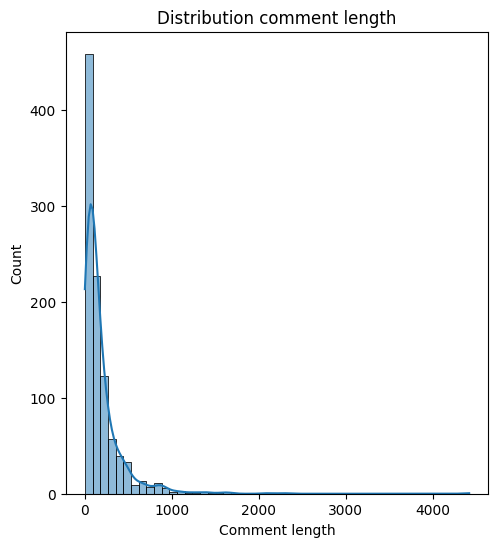

In [11]:
plt.figure(figsize=(12, 6))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution comment length')
plt.xlabel('Comment length')
plt.ylabel('Count')

In [12]:
df['IsToxic'] = df['IsToxic'].astype(int)
df['Text'] = df['Text'].astype(str).apply(preprocess_text)
df['Text'] = df['Text'].astype(str).apply(truncate_text)

In [13]:
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism,text_length
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,people step case people situation lump mess ma...,0,False,False,False,False,False,False,False,False,False,False,False,1558
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,law enforcement train shoot apprehend train sh...,1,True,False,False,False,False,False,False,False,False,False,False,138
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,not reckon black life matter banner hold white...,1,True,False,False,True,False,False,False,False,False,False,False,420
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,large number people like police officer call c...,0,False,False,False,False,False,False,False,False,False,False,False,582
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,arab dude absolutely right shoot extra time sh...,0,False,False,False,False,False,False,False,False,False,False,False,243


In [14]:
df["IsToxic"].value_counts()

,count
IsToxic,
0,538
1,462


<ipython-input-15-2800f69a743a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="IsToxic", data=df, palette=["skyblue", "salmon"])


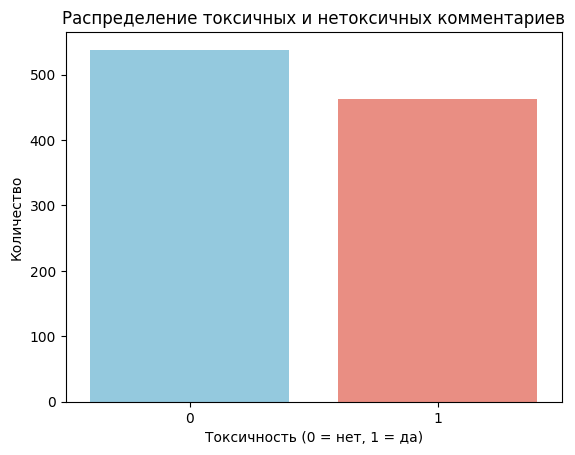

In [15]:
sns.countplot(x="IsToxic", data=df, palette=["skyblue", "salmon"])

plt.title("Распределение токсичных и нетоксичных комментариев")
plt.xlabel("Токсичность (0 = нет, 1 = да)")
plt.ylabel("Количество")
plt.show()


In [16]:
X = df['Text']
y = df['IsToxic']

In [17]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [18]:
X_train.shape

(900,)

In [19]:
X_test.shape

(100,)

In [25]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ("catboost", CatBoostClassifier(iterations=2000, depth=6,
       random_seed=42,
        task_type="GPU"
    ))
])

In [ ]:
pipeline.fit(X_train, y_train)

In [28]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7500    0.8333    0.7895        54
           1     0.7750    0.6739    0.7209        46

    accuracy                         0.7600       100
   macro avg     0.7625    0.7536    0.7552       100
weighted avg     0.7615    0.7600    0.7579       100



## Логистическая регрессия + TFIDF

In [29]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)),
    ("logreg", LogisticRegression(
        C=0.9,                     # регуляризация
        penalty="l2",             # тип регуляризации
        solver="liblinear",       # совместим с 'l1' и 'l2'
        max_iter=1000,
        random_state=42
    ))
])

In [ ]:
pipeline.fit(X_train, y_train)

In [31]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7414    0.7963    0.7679        54
           1     0.7381    0.6739    0.7045        46

    accuracy                         0.7400       100
   macro avg     0.7397    0.7351    0.7362       100
weighted avg     0.7399    0.7400    0.7387       100



## Bert Classification

In [138]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [139]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions)
    }

In [140]:
df = pd.read_csv("youtube_toxic_comments.csv")

In [141]:
df['IsToxic'] = df['IsToxic'].astype(int)
df["Text"] = df["Text"].apply(truncate_text)

In [142]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Text"].tolist(), df["IsToxic"].tolist(), test_size=0.1, stratify=df["IsToxic"]
)

In [143]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [144]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

In [146]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [151]:
training_args = TrainingArguments(
    report_to="tensorboard",
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)


In [152]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

![alt text](image-1.png)

TrainOutput(global_step=570, training_loss=0.14070430493407082, metrics={'train_runtime': 309.3423, 'train_samples_per_second': 29.094, 'train_steps_per_second': 1.843, 'total_flos': 591999874560000.0, 'train_loss': 0.14070430493407082, 'epoch': 10.0})